# Predicting March Madness

### Purpose

The purpose of this notebook is to be able to predict the outcome of horse races in Hong Kong.

### Structure of Notebook
- Import the Data
- Select Features to Potentially Model
- Create Different Sets of Hold-Out Data
- Change Potential Features to Floats
- Create LogLoss Function
- Benchmark Model (Give all matchups 50/50 odds)
- 2nd Benchmark Model (Predict Purely on Betting Markets using LogReg)
- LogReg Model
- List of a few models I haven't gotten to work properly yet
- Visuals for Presentation

### Import Necessary Libraries

In [95]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, train_test_split
from sklearn.metrics import brier_score_loss

In [3]:
!pip install BracketMaker

### Read in Data

In [4]:
all_games_df = pd.read_csv('Data/all_games_df.csv')

In [5]:
all_games_df.head()

,Season,date,is_tourney,home,HTeamID,hscore,road,RTeamID,rscore,line,...,RFG3,RFG3opponent,RFT,Rwins,Rwins_top25,Rwins_top5,Htourny20plus,Rtourny20plus,HBig4Conf,RBig4Conf
0,2004,11/24/2003,0.0,arizona st.,1113.0,83.0,cal st. fullerton,1168.0,76.0,19.0,...,0.362272,0.387864,0.689468,10,0,0,0,0,0,0
1,2004,12/01/2003,0.0,pepperdine,1337.0,74.0,cal st. fullerton,1168.0,78.0,17.0,...,0.362272,0.387864,0.689468,10,0,0,0,0,0,0
2,2004,01/17/2004,0.0,uc irvine,1414.0,74.0,cal st. fullerton,1168.0,67.0,7.0,...,0.362272,0.387864,0.689468,10,0,0,0,0,0,0
3,2004,01/29/2004,0.0,cal poly slo,1142.0,80.0,cal st. fullerton,1168.0,71.0,5.5,...,0.362272,0.387864,0.689468,10,0,0,0,0,0,0
4,2004,02/21/2004,0.0,utah st.,1429.0,87.0,cal st. fullerton,1168.0,61.0,17.0,...,0.362272,0.387864,0.689468,10,0,0,0,0,0,0


In [6]:
all_games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49062 entries, 0 to 49061
Data columns (total 54 columns):
Season            49062 non-null int64
date              49062 non-null object
is_tourney        49062 non-null float64
home              49062 non-null object
HTeamID           49062 non-null float64
hscore            49062 non-null float64
road              49062 non-null object
RTeamID           49062 non-null float64
rscore            49062 non-null float64
line              49062 non-null float64
lineavg           49062 non-null float64
Hwin              49062 non-null int64
HSeed             49062 non-null float64
RSeed             49062 non-null float64
Hconf             49062 non-null object
Hadjem            49062 non-null float64
Hadjo             49062 non-null float64
Hadjd             49062 non-null float64
Hluck             49062 non-null float64
Rconf             49062 non-null object
Radjem            49062 non-null float64
Radjo             49062 non-null float6

In [7]:
tourney_games_df = all_games_df[all_games_df['is_tourney'] == 1]

In [8]:
tourney_games_df.columns

Index(['Season', 'date', 'is_tourney', 'home', 'HTeamID', 'hscore', 'road',
       'RTeamID', 'rscore', 'line', 'lineavg', 'Hwin', 'HSeed', 'RSeed',
       'Hconf', 'Hadjem', 'Hadjo', 'Hadjd', 'Hluck', 'Rconf', 'Radjem',
       'Radjo', 'Radjd', 'Rluck', 'HRankPOM', 'RRankPOM', 'HScore',
       'HOpponentScore', 'HTOmargin', 'HPointMargin', 'HFG', 'HFGopponent',
       'HFG3', 'HFG3opponent', 'HFT', 'Hwins', 'Hwins_top25', 'Hwins_top5',
       'RScore', 'ROpponentScore', 'RTOmargin', 'RPointMargin', 'RFG',
       'RFGopponent', 'RFG3', 'RFG3opponent', 'RFT', 'Rwins', 'Rwins_top25',
       'Rwins_top5', 'Htourny20plus', 'Rtourny20plus', 'HBig4Conf',
       'RBig4Conf'],
      dtype='object')

In [9]:
non_tourney_games_df = all_games_df[all_games_df['is_tourney'] == 0]

In [10]:
test_combos_df = pd.read_csv('Data/test_combos_df_19.csv')
test_combos_df = test_combos_df.sort_values(by=['ID']).reset_index(drop=True)

### Selected Features to Model

I did not end up using these features, but I plan on it in future iterations.

In [11]:
ind_var_selected = [
'is_tourney', 
'HRankPOM',
'RRankPOM',
'line', 
'HTeamID', 
'RTeamID',
'Hwins_top25',
'Rwins_top25',
'HPointMargin',
'RPointMargin',
'HFG',
'RFG',
'HFG3',
'RFG3',
'Hadjem',
'Hadjo',
'Hadjd',
'Hluck',
'Radjem',
'Radjo',
'Radjd',
'Rluck',
'Htourny20plus',
'Rtourny20plus',
'HBig4Conf',
'RBig4Conf', 
'HSeed',
'RSeed'
]

Here I created a set of testing data.

In [12]:
test_ids = test_combos_df['ID'].reset_index(drop=True)
X_test = test_combos_df[['is_tourney','HRankPOM','RRankPOM', 'HTeamID', 'RTeamID', 'Hwins_top25','Rwins_top25', 
                         'HPointMargin','RPointMargin','HFG','RFG','HFG3','RFG3','Hadjem','Hadjo', 
                         'Hadjd','Hluck','Radjem','Radjo','Radjd','Rluck','Htourny20plus', 
                         'Rtourny20plus','HBig4Conf','RBig4Conf','HSeed','RSeed']].reset_index(drop=True)

Here I am going to hold out two years of tournament data to test the model on. I will train the model on all of the data prior to 2017.

In [104]:
# Predict the last two years as a test set (2017, 2018):
temp_df = all_games_df[all_games_df['Season']>2016]
temp_df = temp_df[temp_df['is_tourney']==1]
X_valid = temp_df[ind_var_selected].reset_index(drop=True)
y_valid = temp_df['Hwin'].reset_index(drop=True)

# Train on everything else:
temp_df1 = all_games_df[all_games_df['Season']>2016]
temp_df1 = temp_df1[temp_df1['is_tourney']==0]
temp_df2 = all_games_df[all_games_df['Season']<2017]
combined_temp_df = temp_df1.append(temp_df2)

X_train = combined_temp_df[ind_var_selected].reset_index(drop=True)
y_train = combined_temp_df['Hwin'].reset_index(drop=True)

# For final predictions:
X_train_orig = all_games_df[ind_var_selected].reset_index(drop=True)
y_train_orig = all_games_df['Hwin'].reset_index(drop=True)

In [16]:
X_train_orig.shape

(49062, 28)

In [17]:
X_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 28 columns):
is_tourney       134 non-null float64
HRankPOM         134 non-null int64
RRankPOM         134 non-null int64
line             134 non-null float64
HTeamID          134 non-null float64
RTeamID          134 non-null float64
Hwins_top25      134 non-null int64
Rwins_top25      134 non-null int64
HPointMargin     134 non-null float64
RPointMargin     134 non-null float64
HFG              134 non-null float64
RFG              134 non-null float64
HFG3             134 non-null float64
RFG3             134 non-null float64
Hadjem           134 non-null float64
Hadjo            134 non-null float64
Hadjd            134 non-null float64
Hluck            134 non-null float64
Radjem           134 non-null float64
Radjo            134 non-null float64
Radjd            134 non-null float64
Rluck            134 non-null float64
Htourny20plus    134 non-null int64
Rtourny20plus    134 non-null i

In [18]:
#Create second holdout set to double-check not overfit and check model stability (season 2016)
temp_df16 = all_games_df[all_games_df['Season']==2016]
temp_df16 = temp_df16[temp_df16['is_tourney']==1]
X_valid16 = temp_df16[ind_var_selected].reset_index(drop=True)
y_valid16 = temp_df16['Hwin'].reset_index(drop=True)

temp_df1_16 = all_games_df[all_games_df['Season']==2016]
temp_df1_16 = temp_df1_16[temp_df1_16['is_tourney']==0]
temp_df2_16 = all_games_df[all_games_df['Season']!=2016]
combined_temp_df_16 = temp_df1_16.append(temp_df2_16)

X_train16 = combined_temp_df_16[ind_var_selected].reset_index(drop=True)
y_train16 = combined_temp_df_16['Hwin'].reset_index(drop=True)

### Make all selected features floats

In [19]:
X_test = X_test.astype("float64")

X_train_orig = X_train_orig.astype("float64")
y_train_orig = y_train_orig.astype("float64")

X_train = X_train.astype("float64")
X_valid = X_valid.astype("float64")
y_train = y_train.astype("float64")
y_valid = y_valid.astype("float64")

X_train16 = X_train16.astype("float64")
X_valid16 = X_valid16.astype("float64")
y_train16 = y_train16.astype("float64")
y_valid16 = y_valid16.astype("float64")

### Create a Function to Calculate LogLoss

In [20]:
def LogLoss(predictions, realizations):
    predictions_use = predictions.clip(0)
    realizations_use = realizations.clip(0)
    LogLoss = -np.mean( (realizations_use * np.log(predictions_use)) + 
                        (1 - realizations_use) * np.log(1 - predictions_use) )
    return LogLoss

### Create a Benchmark to try and beat with my Model

In [21]:
bench_5050 = np.repeat(0.5, len(y_valid))

This benchmark finds the LogLoss if the model gives each game a 50/50 probability.

In [22]:
LogLoss(bench_5050, y_valid)

0.6931471805599454

### LogReg Model

This model tries to predict the winners based on the betting markets alone.

In [25]:
Z1 = LogisticRegression(C = 1e9, random_state=23)
Z1.fit(X_train[['line']], y_train)
Z1_pred = pd.DataFrame(Z1.predict_proba(X_valid[['line']]))[1]

In [26]:
LogLoss(Z1_pred, y_valid)

0.5501231760605553

The betting markets clearly did much better than the 50/50 benchmark.

This model uses only each teams adjusted offensive and defensive efficiences from Kenpom.

In [27]:
Z2 = LogisticRegression(C = 1e9, random_state=23)
Z2.fit(X_train[['Hadjo','Hadjd','Radjo','Radjd']], y_train)
Z2_pred = pd.DataFrame(Z2.predict_proba(X_valid[['Hadjo','Hadjd','Radjo','Radjd']]))[1]

In [28]:
LogLoss(Z2_pred, y_valid)

0.5347689637545485

The Kenpom efficiency model does even better than the betting markets.

In [29]:
Z1 = LogisticRegression(C = 1e9, random_state=23)
Z1.fit(X_train16[['line']], y_train16)
Z1_pred = pd.DataFrame(Z1.predict_proba(X_valid16[['line']]))[1]

In [30]:
LogLoss(Z1_pred, y_valid16)

0.5380737902211371

In [31]:
Z2 = LogisticRegression(C = 1e9, random_state=23)
Z2.fit(X_train16[['Hadjo','Hadjd','Radjo','Radjd']], y_train16)
Z2_pred = pd.DataFrame(Z2.predict_proba(X_valid16[['Hadjo','Hadjd','Radjo','Radjd']]))[1]

In [32]:
Z2_pred_probs = Z2.predict_proba(X_valid16[['Hadjo','Hadjd','Radjo','Radjd']])

In [33]:
LogLoss(Z2_pred, y_valid16)

0.5214560672166632

In [34]:
Z3_pred = pd.DataFrame(Z2.predict_proba(X_test[['Hadjo','Hadjd','Radjo','Radjd']]))[1]

In [35]:
Z3_pred_probs = Z2.predict_proba(X_test[['Hadjo','Hadjd','Radjo','Radjd']])

In [36]:
Z3_pred_probs

array([[0.15586459, 0.84413541],
       [0.03906985, 0.96093015],
       [0.09982488, 0.90017512],
       ...,
       [0.28076475, 0.71923525],
       [0.08103121, 0.91896879],
       [0.10904271, 0.89095729]])

In [37]:
len(Z3_pred_probs)

2278

Add Predictions to Dataframe

In [38]:
probs_list = list(range(len(Z3_pred_probs)))

In [39]:
probs = []
for prob in Z3_pred_probs:
        home = prob[1]
        away = prob[0]
        prob_dict = {'home_w_prob' : home, 'away_w_prob' : away}
        probs.append(prob_dict)

In [40]:
df = pd.DataFrame(probs)

In [41]:
preds19 = pd.concat([X_test, df], axis=1, sort=False)

In [42]:
preds19 = preds19[['HTeamID', 'RTeamID', 'home_w_prob']]

In [43]:
preds19.head()

,HTeamID,RTeamID,home_w_prob
0,1113.0,1101.0,0.844135
1,1120.0,1101.0,0.960930
2,1124.0,1101.0,0.900175
3,1125.0,1101.0,0.872582
4,1101.0,1133.0,0.701342


In [44]:
teams_df = pd.read_csv('Data/mens-machine-learning-competition-2019/DataFiles/Teams.csv')

In [45]:
teams_df = teams_df[['TeamID', 'TeamName']]

In [46]:
teams_df = teams_df.rename(columns={"TeamID": "HTeamID"})

In [47]:
preds19 = pd.merge(preds19, teams_df, how='left', on=['HTeamID'])

In [48]:
preds19 = preds19.rename(columns={"TeamName": "HTeamName"})

In [49]:
preds19.head()

,HTeamID,RTeamID,home_w_prob,HTeamName
0,1113.0,1101.0,0.844135,Arizona St
1,1120.0,1101.0,0.960930,Auburn
2,1124.0,1101.0,0.900175,Baylor
3,1125.0,1101.0,0.872582,Belmont
4,1101.0,1133.0,0.701342,Abilene Chr


In [50]:
teams_df = teams_df.rename(columns={"HTeamID": "RTeamID"})

In [51]:
preds19 = pd.merge(preds19, teams_df, how='left', on=['RTeamID'])

In [52]:
preds19 = preds19.rename(columns={"TeamName": "RTeamName"})

In [53]:
preds19 = preds19[['HTeamName', 'RTeamName', 'home_w_prob']]

In [54]:
len(preds19[preds19['home_w_prob'] < 0.5])

11

In [55]:
len(preds19)

2278

In [56]:
preds19.loc[(preds19['HTeamName'] == 'F Dickinson') & (preds19['RTeamName'] == "Prairie View")]

,HTeamName,RTeamName,home_w_prob
660,F Dickinson,Prairie View,0.643591


In [57]:
# sorted(list(preds19['RTeamName'].unique()))

### Decision Tree

In [101]:
# from sklearn.tree import DecisionTreeClassifier

In [102]:
# from sklearn.metrics import log_loss

In [103]:
# dt = DecisionTreeClassifier()
# dt.fit(X_train, y_train)
# dt_prob = pd.DataFrame(dt.predict_proba(X_valid))
# LogLoss(dt_prob[1], y_valid)

### Random Forest

In [61]:
clf = RandomForestClassifier(n_estimators=200, max_depth=3, min_samples_leaf=3)
clf.fit(X_train, y_train)
rf_prob = pd.DataFrame(clf.predict_proba(X_valid))
LogLoss(rf_prob[1], y_valid)

0.5636727226182429

# New Model

In [62]:
# pip install pandas sklearn sportsreference

In [63]:
from sportsreference.ncaab.teams import Teams
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [64]:
# FIELDS_TO_DROP = ['away_points', 'home_points', 'date', 'location',
#                   'losing_abbr', 'losing_name', 'winner', 'winning_abbr',
#                   'winning_name', 'home_ranking', 'away_ranking']

# dataset = pd.DataFrame()
# teams = Teams()
# for team in teams:
#     dataset = pd.concat([dataset, team.schedule.dataframe_extended])

In [65]:
# X = dataset.drop(FIELDS_TO_DROP, 1).dropna().drop_duplicates()
# y = dataset[['home_points', 'away_points']].values
# X_train, X_test, y_train, y_test = train_test_split(X, y)
# parameters = {'bootstrap': False,
#               'min_samples_leaf': 3,
#               'n_estimators': 50,
#               'min_samples_split': 10,
#               'max_features': 'sqrt',
#               'max_depth': 6}
# model = RandomForestRegressor(**parameters)
# model.fit(X_train, y_train)
# print(model.predict(X_test).astype(int), y_test)

### TrueSkill

### Visuals

In [66]:
tourney_games_df.columns

Index(['Season', 'date', 'is_tourney', 'home', 'HTeamID', 'hscore', 'road',
       'RTeamID', 'rscore', 'line', 'lineavg', 'Hwin', 'HSeed', 'RSeed',
       'Hconf', 'Hadjem', 'Hadjo', 'Hadjd', 'Hluck', 'Rconf', 'Radjem',
       'Radjo', 'Radjd', 'Rluck', 'HRankPOM', 'RRankPOM', 'HScore',
       'HOpponentScore', 'HTOmargin', 'HPointMargin', 'HFG', 'HFGopponent',
       'HFG3', 'HFG3opponent', 'HFT', 'Hwins', 'Hwins_top25', 'Hwins_top5',
       'RScore', 'ROpponentScore', 'RTOmargin', 'RPointMargin', 'RFG',
       'RFGopponent', 'RFG3', 'RFG3opponent', 'RFT', 'Rwins', 'Rwins_top25',
       'Rwins_top5', 'Htourny20plus', 'Rtourny20plus', 'HBig4Conf',
       'RBig4Conf'],
      dtype='object')

All of this code was written in the attempt to get make it easy to make some basic visuals for Adjusted Offensive and Defensive Efficiency. The problem that I was running into was that each row of data had two teams, and I was having trouble plotting every team on the same chart. I therefore created a new dataset with a separate row for every team.

In [100]:
# tourney_games_df['HSeed']

In [96]:
# tourney_games_df.groupby('HSeed')['Hadjo'].mean()

In [97]:
# tourney_games_df.groupby('RSeed')['Radjo'].mean()

In [98]:
# tourney_games_df.groupby('HSeed')['line'].mean()

In [99]:
# tourney_games_df.groupby('RSeed')['line'].mean()

In [72]:
trial = tourney_games_df[['HSeed']]

In [73]:
trial = trial.rename(columns={"HSeed": "Seed"})

In [74]:
trial2 = tourney_games_df[['RSeed']]

In [75]:
trial2 = trial2.rename(columns={"RSeed": "Seed"})

In [76]:
trial = trial.append(trial2)

In [77]:
trial2 = tourney_games_df[['Hadjo']]

In [78]:
trial2 = trial2.rename(columns={"Hadjo": "Adjo"})

In [79]:
trial3 = tourney_games_df[['Radjo']]

In [80]:
trial3 = trial3.rename(columns={"Radjo": "Adjo"})

In [81]:
trial2 = trial2.append(trial3)

In [82]:
trial = pd.concat([trial, trial2], axis=1)

In [83]:
trial2 = tourney_games_df[['Hadjd']]

In [84]:
trial2 = trial2.rename(columns={"Hadjd": "Adjd"})

In [85]:
trial3 = tourney_games_df[['Radjd']]

In [86]:
trial3 = trial3.rename(columns={"Radjd": "Adjd"})

In [87]:
trial2 = trial2.append(trial3)

In [88]:
trial = pd.concat([trial, trial2], axis=1)

In [89]:
trial

,Seed,Adjo,Adjd
55,6.0,113.6,95.0
70,8.0,112.3,95.0
254,1.0,120.8,88.5
255,2.0,114.7,92.9
257,3.0,115.6,94.1
...,...,...,...
48749,16.0,102.9,102.9
48789,16.0,104.6,111.2
48924,12.0,112.9,100.7
49012,16.0,102.3,110.6


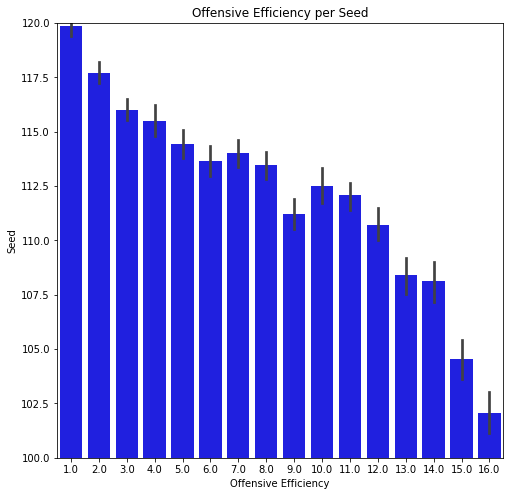

In [93]:
plt.figure(figsize = (8,8))
sns.barplot(trial['Seed'], trial['Adjo'], color = 'blue')
plt.title("Offensive Efficiency per Seed")
plt.xlabel("Offensive Efficiency")
plt.ylabel("Seed")
plt.ylim(100, 120)
plt.show()

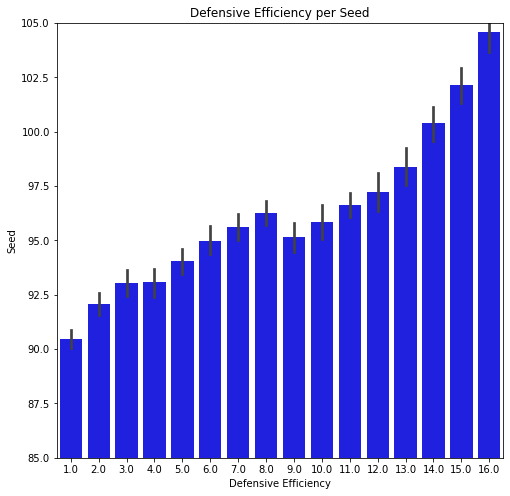

In [94]:
plt.figure(figsize = (8,8))
sns.barplot(trial['Seed'], trial['Adjd'], color = 'blue')
plt.title("Defensive Efficiency per Seed")
plt.xlabel("Defensive Efficiency")
plt.ylabel("Seed")
plt.ylim(85, 105)
plt.show()

In [688]:
tourney_games_df.columns

Index(['Season', 'date', 'is_tourney', 'home', 'HTeamID', 'hscore', 'road',
       'RTeamID', 'rscore', 'line', 'lineavg', 'Hwin', 'HSeed', 'RSeed',
       'Hconf', 'Hadjem', 'Hadjo', 'Hadjd', 'Hluck', 'Rconf', 'Radjem',
       'Radjo', 'Radjd', 'Rluck', 'HRankPOM', 'RRankPOM', 'HScore',
       'HOpponentScore', 'HTOmargin', 'HPointMargin', 'HFG', 'HFGopponent',
       'HFG3', 'HFG3opponent', 'HFT', 'Hwins', 'Hwins_top25', 'Hwins_top5',
       'RScore', 'ROpponentScore', 'RTOmargin', 'RPointMargin', 'RFG',
       'RFGopponent', 'RFG3', 'RFG3opponent', 'RFT', 'Rwins', 'Rwins_top25',
       'Rwins_top5', 'Htourny20plus', 'Rtourny20plus', 'HBig4Conf',
       'RBig4Conf'],
      dtype='object')

In [689]:
x = tourney_games_df[['Hwin']]

In [690]:
y = tourney_games_df[['Hwin']]

In [691]:
blank_list = []
for i in y['Hwin']:
    if i == 1:
        i = 0
        blank_dict = {'Win': i}
        blank_list.append(blank_dict)
    else:
        i = 1
        blank_dict = {'Win': i}
        blank_list.append(blank_dict)
    

In [692]:
y = pd.DataFrame(blank_list)

In [693]:
x = x.rename(columns={"Hwin": "Win"})

In [694]:
x = x.reset_index(drop=True)

In [695]:
y = y.reset_index(drop=True)

In [696]:
x = x.append(y)

In [697]:
x = x.reset_index(drop=True)

In [698]:
trial = trial.reset_index(drop=True)

In [699]:
trial = pd.concat([trial, x], axis=1)

In [701]:
trial.head()

,Seed,Adjo,Adjd,Win
0,6.0,113.6,95.0,1
1,8.0,112.3,95.0,1
2,1.0,120.8,88.5,1
3,2.0,114.7,92.9,0
4,3.0,115.6,94.1,0


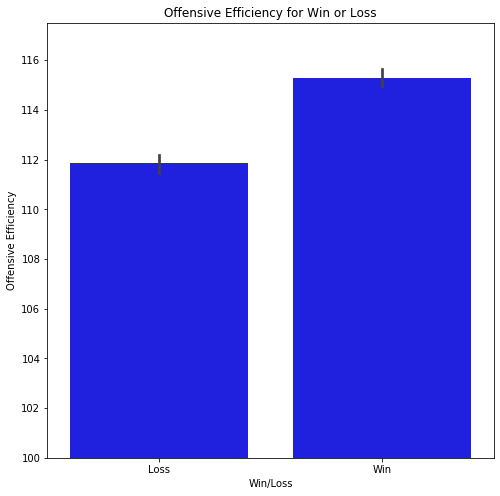

In [726]:
plt.figure(figsize = (8,8))
sns.barplot(trial['Win'], trial['Adjo'], color = 'blue')
plt.title("Offensive Efficiency for Win or Loss")
plt.xlabel("Win/Loss")
plt.ylabel("Offensive Efficiency")
plt.ylim(100, 117.5)
plt.xticks([0, 1], ['Loss', 'Win'])
plt.show()

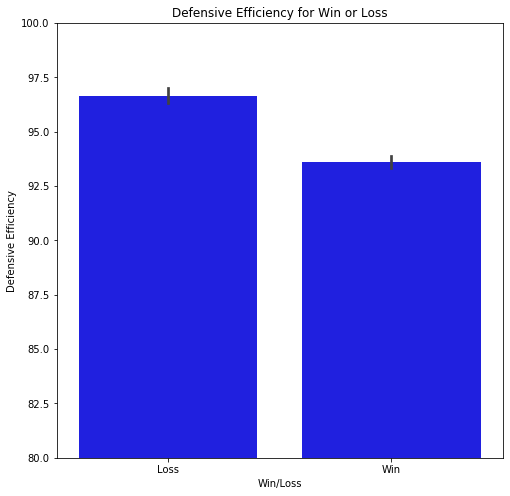

In [725]:
plt.figure(figsize = (8,8))
sns.barplot(trial['Win'], trial['Adjd'], color = 'blue')
plt.title("Defensive Efficiency for Win or Loss")
plt.xlabel("Win/Loss")
plt.ylabel("Defensive Efficiency")
plt.ylim(80, 100)
plt.xticks([0, 1], ['Loss', 'Win'])
plt.show()